In [1]:
#!/usr/bin/env python3
"""
Build a CSV of all USGS CONUS stream (ST) stations that measure discharge (00060),
including drainage area (sq mi), latitude, and longitude.

Requires: pip install dataretrieval pandas
"""

import time
from typing import List
import pandas as pd
from dataretrieval import nwis

# 48 states + DC (exclude AK, HI, territories)
CONUS_STATES = [
    "AL","AZ","AR","CA","CO","CT","DE","DC","FL","GA","ID","IL","IN","IA","KS","KY",
    "LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC",
    "ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"
]

OUT_CSV = "conus_usgs_discharge_stations.csv"

def fetch_state(state_cd: str) -> pd.DataFrame:
    """
    Query NWIS Site Service via dataretrieval for one state.
    Filters:
      - siteType = ST (streams)
      - hasDataTypeCd=iv (instantaneous) to ensure parameterCd filter is valid
      - parameterCd=00060 (discharge)
    """
    try:
        # dataretrieval passes args to the Site Service (RDB). This avoids the JSON 400s.
        df, _md = nwis.what_sites(
            stateCd=state_cd,
            siteType="ST",
            hasDataTypeCd="iv",
            parameterCd="00060",
            seriesCatalogOutput=True,  # ensures parameterCd filter is supported
        )
        if df is None or df.empty:
            return pd.DataFrame()
        return df
    except Exception as e:
        print(f"[WARN] {state_cd}: {e}")
        return pd.DataFrame()

def col(df: pd.DataFrame, options: List[str]):
    """Return the first existing column from 'options', else None."""
    for c in options:
        if c in df.columns:
            return c
    return None

def normalize(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty:
        return pd.DataFrame()

    # Column names can vary slightly; resolve robustly
    site_no_c   = col(df, ["site_no"])
    agency_c    = col(df, ["agency_cd"])
    name_c      = col(df, ["station_nm"])
    state_c     = col(df, ["state_cd"])   # often numeric ANSI; fine for bookkeeping
    site_type_c = col(df, ["site_tp_cd"])
    huc_c       = col(df, ["huc_cd", "hucCd"])
    lat_c       = col(df, ["dec_lat_va", "lat", "latitude"])
    lon_c       = col(df, ["dec_long_va","lon","longitude"])
    drain_c     = col(df, ["drain_area_va", "contrib_drain_area_va"])

    keep = []
    for _, r in df.iterrows():
        keep.append({
            "agency_cd": r.get(agency_c, None),
            "site_no": r.get(site_no_c, None),
            "station_nm": r.get(name_c, None),
            "state_cd": r.get(state_c, None),
            "site_tp_cd": r.get(site_type_c, None),
            "huc_cd": r.get(huc_c, None),
            "lat": pd.to_numeric(r.get(lat_c, None), errors="coerce"),
            "lon": pd.to_numeric(r.get(lon_c, None), errors="coerce"),
            "drainage_area_sqmi": pd.to_numeric(r.get(drain_c, None), errors="coerce"),
        })
    out = pd.DataFrame(keep)

    # Basic cleanup
    out = out.dropna(subset=["site_no"]).drop_duplicates(subset=["site_no"]).reset_index(drop=True)
    return out

def fill_missing_drainage(df: pd.DataFrame, batch_size: int = 200) -> pd.DataFrame:
    """For rows missing drainage area, bulk-fetch site info and fill 'drainage_area_sqmi'."""
    need = df["drainage_area_sqmi"].isna()
    if not need.any():
        return df

    sites = df.loc[need, "site_no"].astype(str).tolist()
    filled = {}
    for i in range(0, len(sites), batch_size):
        chunk = sites[i:i+batch_size]
        try:
            info, _md = nwis.get_info(sites=",".join(chunk))
            if info is None or info.empty:
                continue
            # get_info returns site metadata; look for drain_area_va
            if "site_no" in info.columns:
                info = info.drop_duplicates(subset=["site_no"])
                # column may be 'drain_area_va' (total) or have only contrib; prefer total
                drain_c = "drain_area_va" if "drain_area_va" in info.columns else (
                    "contrib_drain_area_va" if "contrib_drain_area_va" in info.columns else None
                )
                if drain_c:
                    for _, r in info.iterrows():
                        val = pd.to_numeric(r.get(drain_c, None), errors="coerce")
                        if pd.notna(val):
                            filled[str(r["site_no"])] = float(val)
        except Exception as e:
            print(f"[INFO] fill chunk {i}-{i+batch_size}: {e}")
        time.sleep(0.05)  # be polite

    if filled:
        df.loc[need, "drainage_area_sqmi"] = df.loc[need, "site_no"].map(filled)
    return df

def main():
    frames = []
    for i, st in enumerate(CONUS_STATES, 1):
        print(f"[{i}/{len(CONUS_STATES)}] {st} ...")
        raw = fetch_state(st)
        norm = normalize(raw)
        if not norm.empty:
            frames.append(norm)
        time.sleep(0.05)  # throttle a bit

    if not frames:
        print("No rows found.")
        pd.DataFrame(columns=[
            "agency_cd","site_no","station_nm","state_cd","site_tp_cd","huc_cd","lat","lon","drainage_area_sqmi"
        ]).to_csv(OUT_CSV, index=False)
        print(f"Saved empty CSV with headers to {OUT_CSV}")
        return

    df = pd.concat(frames, ignore_index=True)
    # Keep only valid coordinates and stream sites (safety)
    df = df[df["site_tp_cd"] == "ST"]
    df = df[df["lat"].notna() & df["lon"].notna()].copy()

    # Try to fill missing drainage areas
    df = fill_missing_drainage(df)

    # Final ordering & write
    cols = ["agency_cd","site_no","station_nm","state_cd","site_tp_cd","huc_cd","lat","lon","drainage_area_sqmi"]
    df = df[cols].drop_duplicates(subset=["site_no"]).reset_index(drop=True)

    print(f"Writing {len(df)} rows to {OUT_CSV}")
    df.to_csv(OUT_CSV, index=False)
    print("Done.")

if __name__ == "__main__":
    main()


[1/49] AL ...
[2/49] AZ ...
[3/49] AR ...
[4/49] CA ...
[5/49] CO ...
[6/49] CT ...
[7/49] DE ...
[8/49] DC ...
[9/49] FL ...
[10/49] GA ...
[11/49] ID ...
[12/49] IL ...
[13/49] IN ...
[14/49] IA ...
[15/49] KS ...
[16/49] KY ...
[17/49] LA ...
[18/49] ME ...
[19/49] MD ...
[20/49] MA ...
[21/49] MI ...
[22/49] MN ...
[23/49] MS ...
[24/49] MO ...
[25/49] MT ...
[26/49] NE ...
[27/49] NV ...
[28/49] NH ...
[29/49] NJ ...
[30/49] NM ...
[31/49] NY ...
[32/49] NC ...
[33/49] ND ...
[34/49] OH ...
[35/49] OK ...
[36/49] OR ...
[37/49] PA ...
[38/49] RI ...
[39/49] SC ...
[40/49] SD ...
[41/49] TN ...
[42/49] TX ...
[43/49] UT ...
[44/49] VT ...
[45/49] VA ...
[46/49] WA ...
[47/49] WV ...
[48/49] WI ...
[49/49] WY ...
Writing 12563 rows to conus_usgs_discharge_stations.csv
Done.


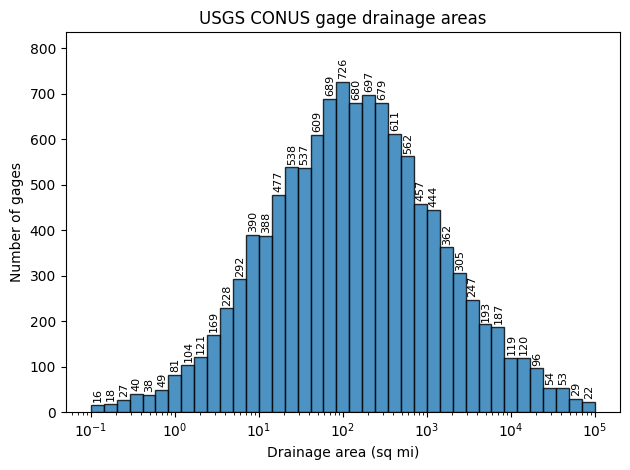

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# da = your 1D array/Series of drainage areas (positive values only)
bins = np.logspace(np.log10(0.1), np.log10(1e5), 40)

fig, ax = plt.subplots()
n, bins, patches = ax.hist(da, bins=bins, edgecolor="black", alpha=0.8)  # density=False -> counts
ax.set_xscale("log")
ax.set_xlabel("Drainage area (sq mi)")
ax.set_ylabel("Number of gages")
ax.set_title("USGS CONUS gage drainage areas")

# Put counts on top of bars
labels = [f"{int(c):,}" if c > 0 else "" for c in n]
ax.bar_label(patches, labels=labels, padding=2, fontsize=8, rotation=90)

ax.margins(y=0.15)   # headroom for labels
plt.tight_layout()
plt.show()
